# Running source extraction algorithms

In this notebook, we use simulated data to introduce source extraction algorithms.

## Setup plotting

In [1]:
%matplotlib inline
from thunder import Colorize
image = Colorize.image
import seaborn as sns
figsize = 12

## Create data with ground truth

In [2]:
data, ts, truth = tsc.makeExample('sources', centers=10, noise=1.0, returnParams=True)

The data set is an `Images` object, in this case 100 images of size 100 x 200

In [3]:
data

Images
nrecords: 100
dtype: float
dims: min=(0, 0), max=(99, 199), count=(100, 200)

Look at the mean image

In [4]:
im = data.mean()

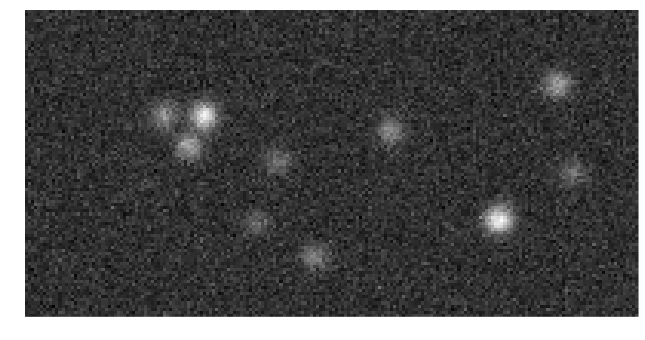

In [5]:
image(im, size=11)

Confirm that the ground truth exactly matches the sources, using the `masks` method to see the source outlines

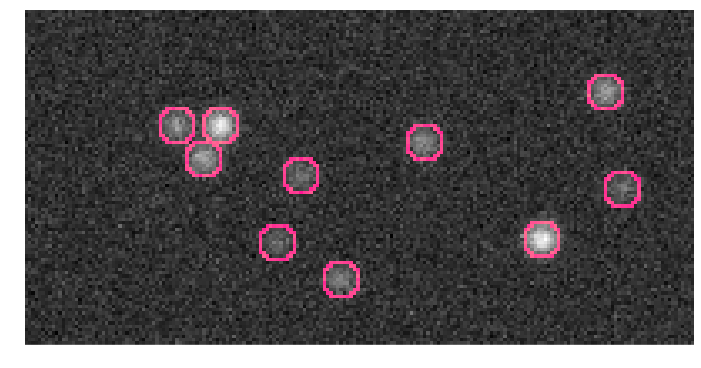

In [6]:
image(truth.masks((100,200), base=im, outline=True), size=figsize)

## Run an algorithm

Many common algorithms with sensible defaults are availiable directly through the top level `SourceExtraction` class and can be called by name.

We'll start by using the `localmax` method, which is an example of a "feature method". These methods compute simple statistics on the data and them use image-based operations to identifty likely sources. The local max algorithms simply identified sources around local peaks in the mean image.

In [7]:
from thunder import SourceExtraction
model = SourceExtraction('localmax')

We can use the model to `fit` the data, which yields a `SourceModel`

In [8]:
sources = model.fit(data)

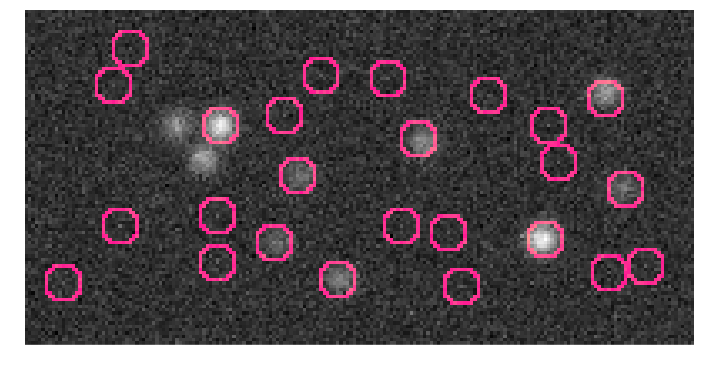

In [9]:
image(sources.masks((100, 200), base=im, outline=True), size=figsize)

Some methods have parameters, such as the `maxSources` method for this method, which will likely improve the result by eliminating false positives

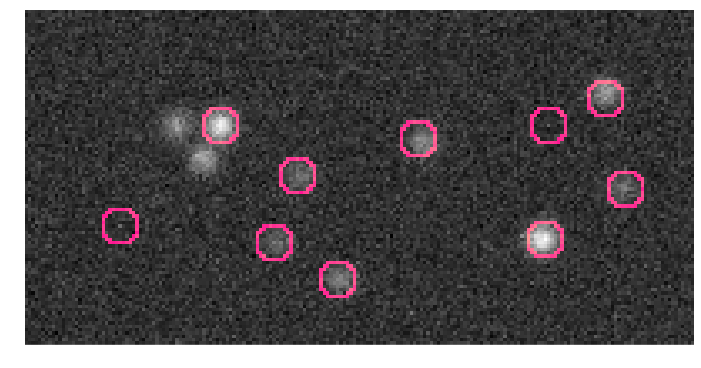

In [10]:
sources = SourceExtraction('localmax', maxSources=10).fit(data)
image(sources.masks((100, 200), base=im, outline=True), size=figsize)

## Run a block algorithm

Another classes of algorithms perform operations on spatio temporal blocks to identify sources locally, and then merge sources across blocks. A variety of local operations are possible; many are based on matrix factorization, for example, non-negative matrix factorization.

In [11]:
model = SourceExtraction('nmf')

When fitting this mode, we need to specify the size of the block as an argument

In [12]:
sources = model.fit(data, size=(25,25))

In [13]:
sources

SourceModel
12 sources

Look at the result; it's likely not very good due to artifacts at the block boundaries

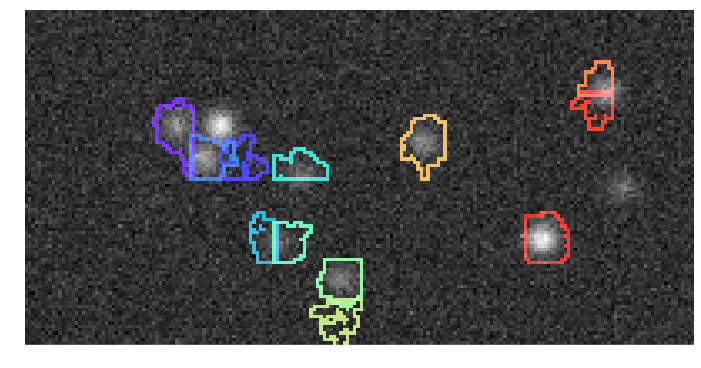

In [14]:
image(sources.masks((100, 200), base=im, outline=True, color='random'), size=figsize)

We can improve things by padding the blocks through an extra argument during fitting

In [15]:
sources = model.fit(data, size=(25,25), padding=7)

In [16]:
sources

SourceModel
43 sources

You'll find that all sources were found, but many now overlap (due to the padded region)

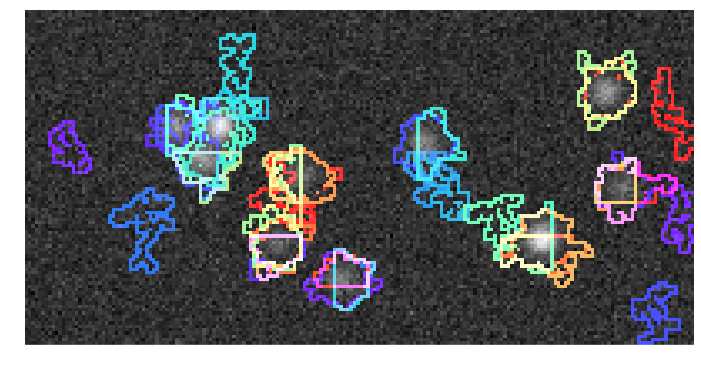

In [17]:
image(sources.masks((100, 200), base=im, outline=True, color='random'), size=figsize)

This can be improved through the use of a custom merger, for example, the `OverlapBlockMerger`, which will merge sources from each block to those in adjacent blocks so long as they overlap by a certain fraction.

In [18]:
from thunder.extraction import OverlapBlockMerger

In [19]:
model = SourceExtraction('nmf', merger=OverlapBlockMerger(0.25), minArea=100)

In [20]:
sources = model.fit(data, size=(25,25), padding=7)

In [21]:
sources

SourceModel
9 sources

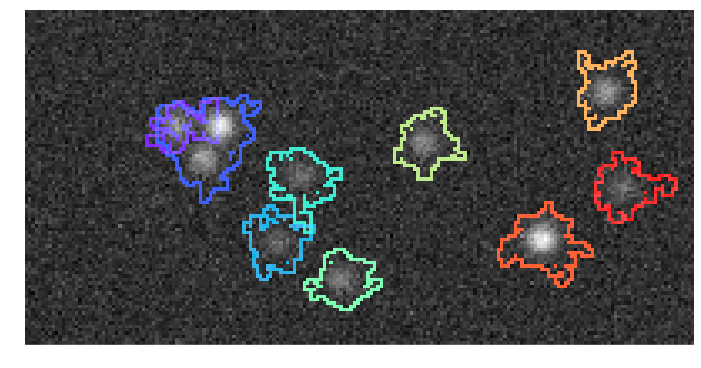

In [22]:
image(sources.masks((100, 200), base=im, outline=True, color='random'), size=figsize)